# Setup Dependancies

In [5]:
!git clone --quiet https://github.com/GrayXu/Virtual-Try-On-Flask
!mv nitriders_myntra/*.py /content/

fatal: destination path 'Virtual-Try-On-Flask' already exists and is not an empty directory.
zsh:1: no matches found: nitriders_myntra/*.py


In [6]:
!pip --quiet install tensorflow==1.12.0
!pip --quiet install torch==1.2.0
!pip --quiet install torchvision==0.2.0

zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip


In [7]:
from google.colab import drive
drive.mount('drive')

!yes | unzip -qq drive/My\ Drive/datasets/Myntra/CP-VTON/checkpoints.zip

ModuleNotFoundError: No module named 'google'

In [7]:
from google.colab import drive
drive.mount('drive')

!yes | unzip -qq drive/My\ Drive/datasets/Myntra/CP-VTON/checkpoints.zip

ModuleNotFoundError: No module named 'google'

In [8]:
!wget -c -q https://rkwgsg.ch.files.1drv.com/y4mguZFHtcodQAuxYH7bHTwQyh2H_DAorXfaeHtC29b4P1_BMREcBHOhYcjSUjPDR_2xz6886gKWWa9Bk4oPRVj8k5fdZAPHUM5J3C79d1tkjKTXYurZkap34ZKexaMephF7yAuQ56VqFnFFlQ5UHI_zBOdjrmpQlavi8lxCxdffFtViTUmZcdbwj3R1HRn6B7XXDdH9LmVfFlnczQPNFEJRQ -O dataset.zip
!mkdir dataset
!unzip -qq dataset.zip -d dataset
!unzip drive/My\ Drive/datasets/Myntra/CP-VTON/clothes.zip

zsh:1: command not found: wget
unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.
unzip:  cannot find or open drive/My Drive/datasets/Myntra/CP-VTON/clothes.zip, drive/My Drive/datasets/Myntra/CP-VTON/clothes.zip.zip or drive/My Drive/datasets/Myntra/CP-VTON/clothes.zip.ZIP.


In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2 as cv
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

ModuleNotFoundError: No module named 'PIL'

In [10]:
!zip output.zip output/*

zsh:1: no matches found: output/*


# JPPNet

In [11]:
from JPPNet import JPP

start = time.time()
jpp = JPP("checkpoints/jpp.pb")
image = np.array(Image.open("image_5.jpg"))
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
result = jpp.predict(image)
print("time:"+str(time.time()-start))

ModuleNotFoundError: No module named 'tensorflow'

In [1]:
def getPoseData(pose):
  contents = []
  trusts = []
  for i in range(16):
      tmp = np.argmax(pose[:, :, i])
      y = tmp % pose.shape[1]
      x = tmp//pose.shape[1]
      contents.append([y, x, 1])
      if i not in [0, 1, 4, 5]:
          trusts.append(sum([pose[x, y, i], pose[x+1, y, i], pose[x, y+1, i],
                             pose[x-1, y, i], pose[x, y-1, i], pose[x+1, y-1, i],
                             pose[x-1, y+1, i], pose[x+1, y+1, i], 
                             pose[x-1, y+1, i],])/8)
  return np.array(contents), min(trusts)

def getPoseMap(pose_data, image):
  pose_map = image.copy()
  dots = image.copy()
  for i in range(pose_data.shape[0]):
    pointx = pose_data[i, 0]
    pointy = pose_data[i, 1]
    r = 3
    if pointx > 1 and pointy > 1:
      cv.putText(pose_map, str(i), (pointx-2*r, pointy), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
      cv.rectangle(dots, (pointx-r, pointy-r), (pointx+r, pointy+r), (0, 0, 255), -1)

  points = [(10, 11), (11, 12), (12, 8), (8, 13), (13, 14), (14, 15), (12, 7), (7, 13), (8, 6), (6, 2), (6, 3)]
  dist = []
  for (p, q) in points:
    cv.line(dots, (pose_data[p, 0], pose_data[p, 1]), (pose_data[q, 0], pose_data[q, 1]), (0, 255, 255), 2)
    dist.append(np.linalg.norm(pose_data[p] - pose_data[q]))

    with open('dist.npy', 'wb') as f:
      np.save(f, dist)
  return pose_map, dots

In [10]:
def pred_pose():
  pose, parse = result[0][0], result[1][0]
  parse = parse + np.array(parse == 16, dtype='uint8') * \
              (-(16-9))+np.array(parse == 17, dtype='uint8')*(-(17-9))
  parse = np.array(parse[:, :, 0], dtype="uint8")

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 3))
  fig.suptitle('JPPNET', fontsize=20)

  ax1.set_title('Parse', fontsize=15)
  ax1.imshow(parse)

  pose_data, trusts = getPoseData(pose)
  pose_map, dots = getPoseMap(pose_data, image)

  ax2.set_title('Pose', fontsize=15)
  ax2.imshow(pose_map)

  ax3.set_title('Dots', fontsize=15)
  ax3.imshow(dots)

  plt.tight_layout()
  plt.subplots_adjust(top=0.8)
  plt.show()

  # cv.imwrite('pose.jpg', pose_map)
  # cv.imwrite('dots.jpg', dots)

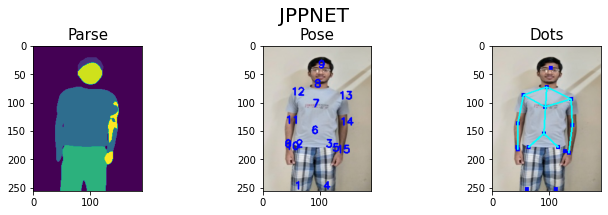

In [15]:
pred_pose()

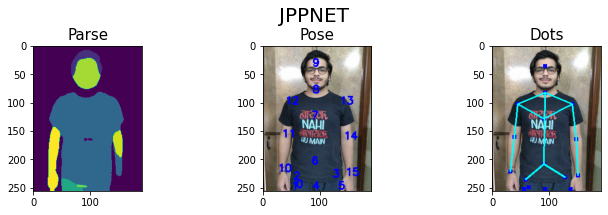

In [19]:
pred_pose()

In [31]:
def visualize(image, cloth, warp, out, count):
  out_img = np.array((np.transpose(out.detach().cpu().numpy()[
                      0], axes=(1, 2, 0))+1)/2*255, dtype='uint8')
  warp_img = np.array((np.transpose(warp.detach().cpu().numpy()[
                      0], axes=(1, 2, 0))+1)/2*255, dtype='uint8')

  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(10, 3))
  fig.suptitle('CP-VTON', fontsize=20)

  ax1.set_title('Input Cloth', fontsize=15)
  ax1.imshow(cloth)

  ax2.set_title('Input Image', fontsize=15)
  ax2.imshow(image[:230])

  ax3.set_title('Warp Cloth', fontsize=15)
  ax3.imshow(warp_img)

  ax4.set_title('Output Image', fontsize=15)
  ax4.imshow(out_img[:230])

  plt.tight_layout()
  plt.subplots_adjust(top=0.75)
  plt.show()

  cv.imwrite('output/' + count, out_img)

In [32]:
from Model import Model

model = Model("checkpoints/jpp.pb",
                "checkpoints/gmm.pth", 
                "checkpoints/tom.pth", use_cuda=True)

def predict(image_path, cloth_path, model, count):
  cloth = np.array(Image.open(cloth_path))
  image = np.array(Image.open(image_path))
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

  cpvton = model.cpvton
  pose, parse = result[0][0], result[1][0]

  pose_data, trusts = model.__getPoseData__(pose)
  image, pose_data, parse = model.__cropByPoseData__(image, pose_data, parse)
  pose_map = model.__getPoseMap__(pose_data)

  parse = parse + np.array(parse == 16, dtype='uint8') * (-(16-9))+np.array(parse == 17, dtype='uint8')*(-(17-9))
  parse = np.array(parse[:, :, 0], dtype="uint8")

  start = time.time()
  (out, warp) = cpvton.predict(parse, pose_map, image, cloth)
  print("time:"+str(time.time()-start))

  visualize(image, cloth, warp, out, count)

initialization method [normal]
initialization method [normal]
use_cuda = True


upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.032109737396240234


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


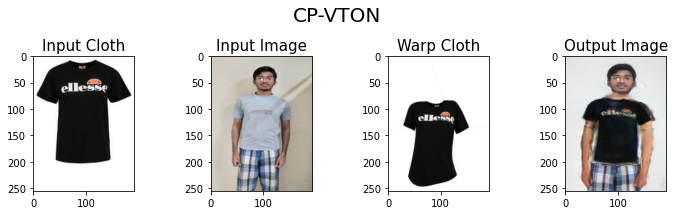

In [35]:
list_cloth = os.listdir('clothes')
for i, cloth_path in enumerate(list_cloth):
  if i == 0:
    predict('image_4.jpg', 'clothes/' + cloth_path, model, 'image_4' + str(i) + '.jpg')

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03306293487548828


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


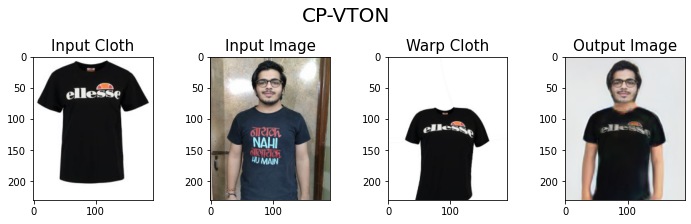

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03307342529296875


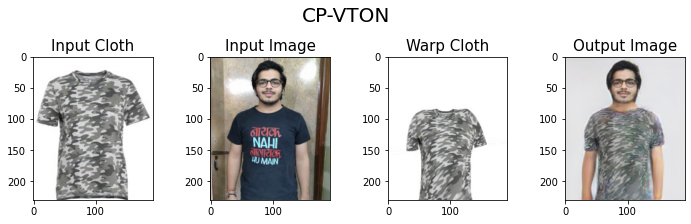

In [36]:
list_cloth = os.listdir('clothes')
for i, cloth_path in enumerate(list_cloth):
  if i == 0 or i == 16:
    predict('image_1.jpg', 'clothes/' + cloth_path, model, 'image_final_1' + str(i) + '.jpg')

# Rough Work

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.032727956771850586


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


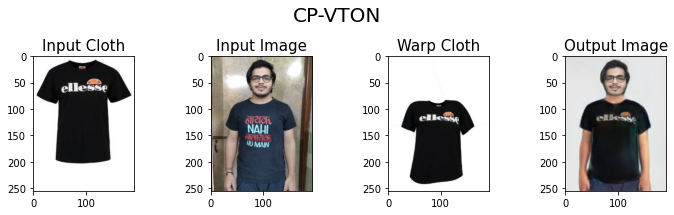

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03303384780883789


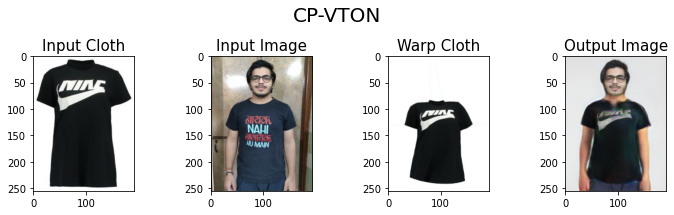

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03235888481140137


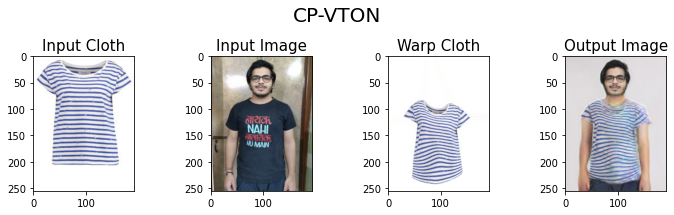

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03414797782897949


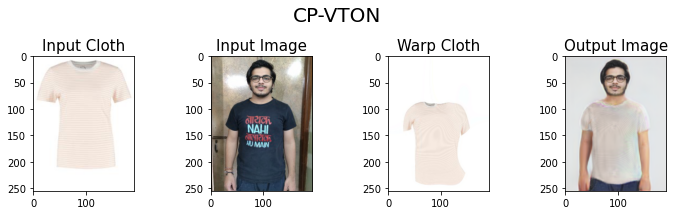

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03214764595031738


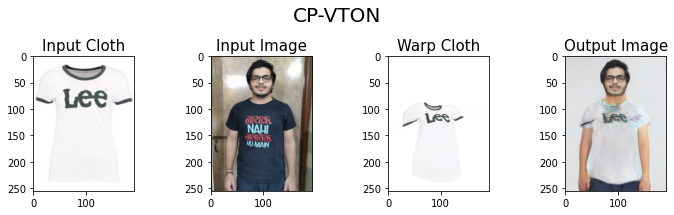

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03512263298034668


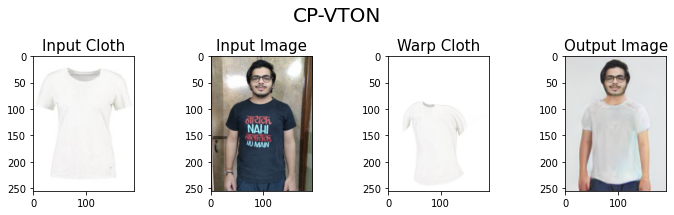

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03194618225097656


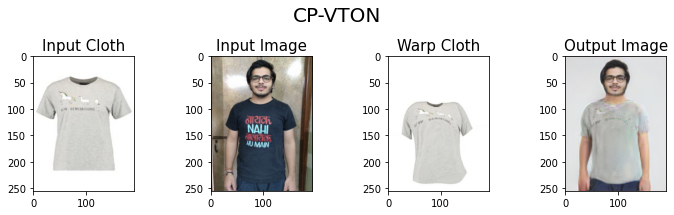

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.032117605209350586


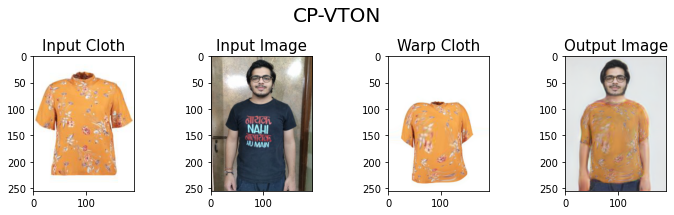

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.034037113189697266


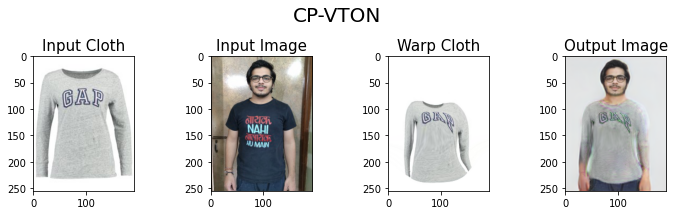

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.032848358154296875


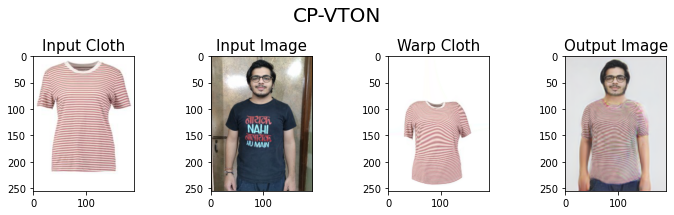

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03389859199523926


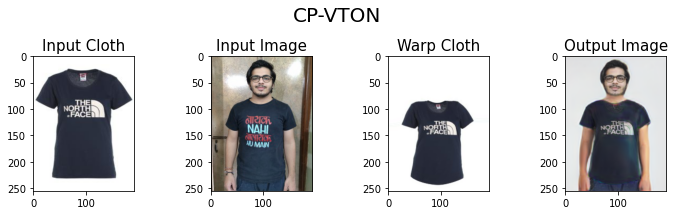

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03339052200317383


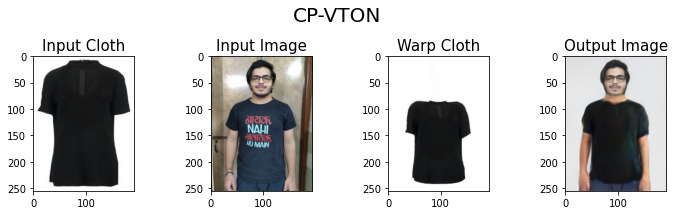

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03217148780822754


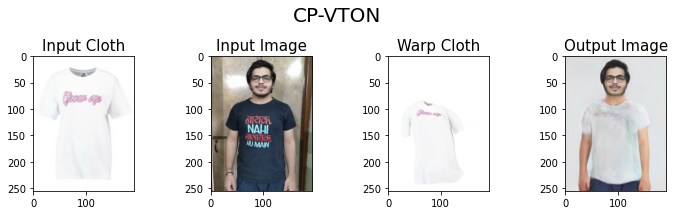

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.032479286193847656


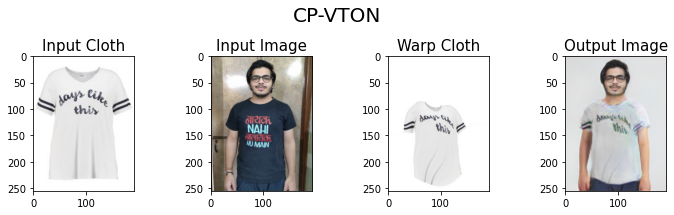

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03237509727478027


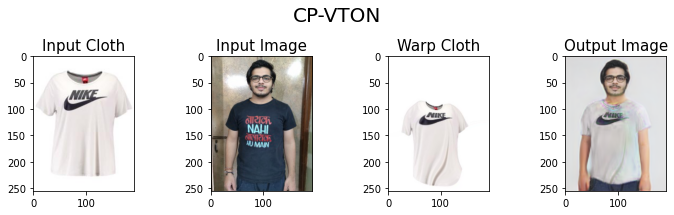

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.03276181221008301


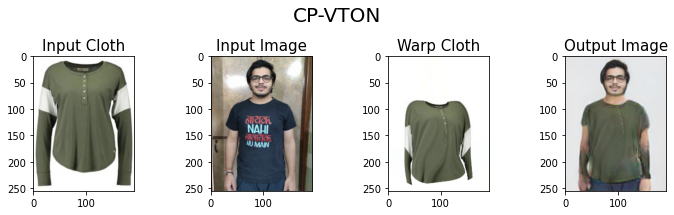

upper:0,bounder:256,left:0,right:192
after crop shape:(256, 192, 3)
time:0.0345759391784668


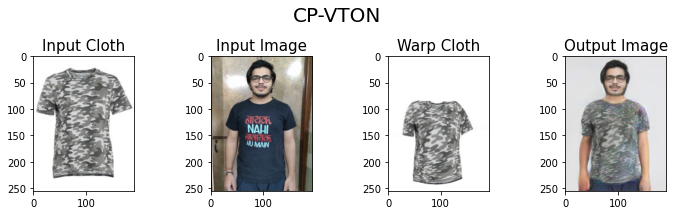

In [157]:
list_cloth = os.listdir('clothes')
for i, cloth_path in enumerate(list_cloth):
  predict('image_1.jpg', 'clothes/' + cloth_path, model, 'image_1' + str(i) + '.jpg')


In [21]:
from Model import Model
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

model = Model("checkpoints/jpp.pb",
              "checkpoints/gmm.pth", 
              "checkpoints/tom.pth", use_cuda=True)

initialization method [normal]
initialization method [normal]
use_cuda = True


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.suptitle('Final Output', fontsize=20)

cloth = np.array(Image.open("cloth.jpg"))
ax1.set_title('Input Cloth', fontsize=15)
ax1.imshow(cloth)

# image = np.array(Image.open("0.jpg"))
ax2.set_title('Input Image', fontsize=15)
ax2.imshow(image)

start = time.time()
result, trusts = model.predict(image, cloth, need_pre=True, check_dirty=True)
if result is not None:
    end = time.time()
    ax3.set_title('Input Image', fontsize=15)
    ax3.imshow(result)
    print("time:"+str(end-start))
    print("Confidence"+str(trusts))

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.03697371482849121


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


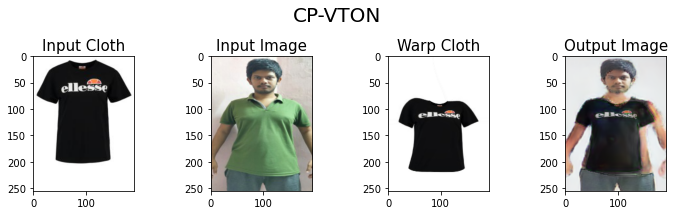

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.032128095626831055


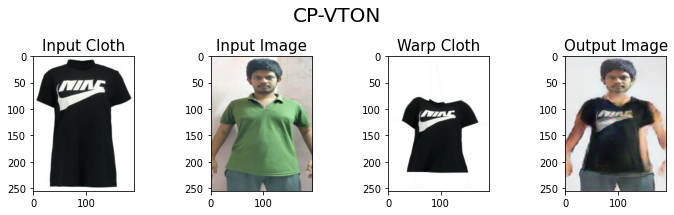

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.03275489807128906


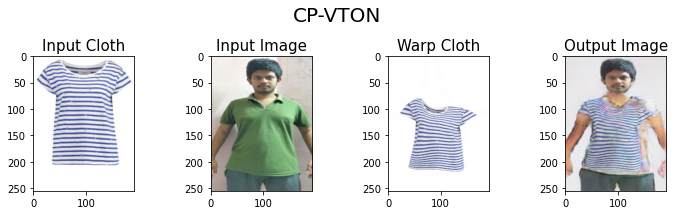

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.032311439514160156


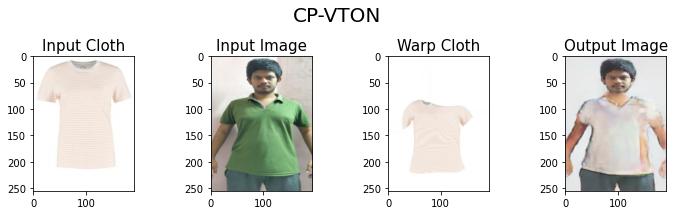

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.03464531898498535


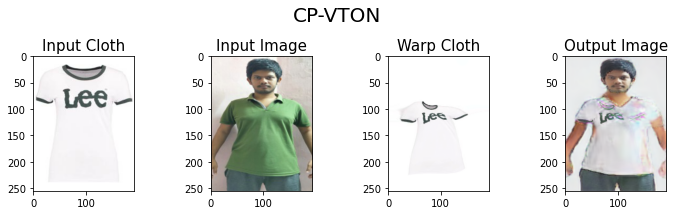

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.03314065933227539


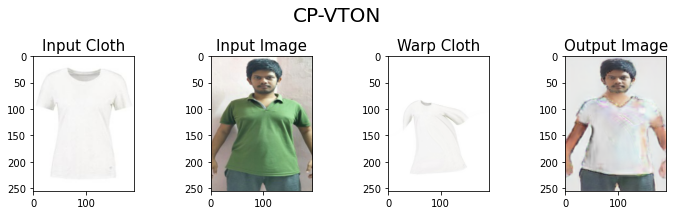

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.0325312614440918


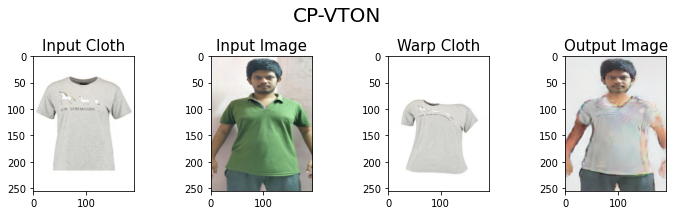

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.0339202880859375


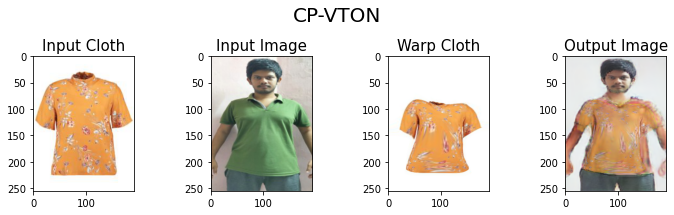

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.03272223472595215


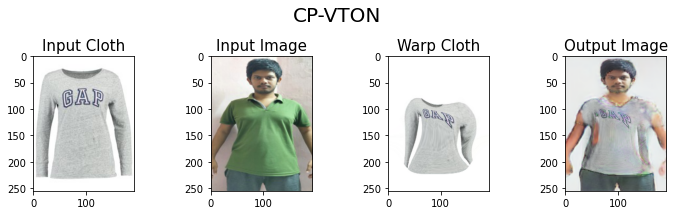

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.03211665153503418


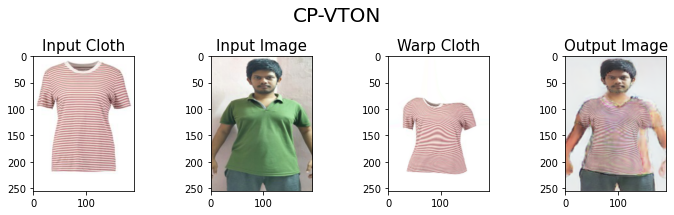

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.03424882888793945


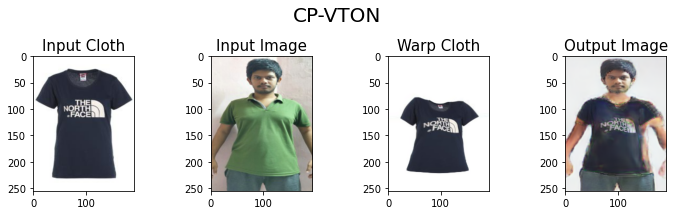

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.03258562088012695


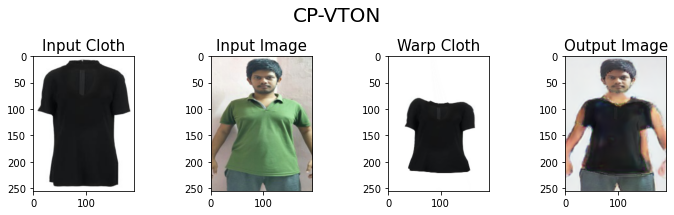

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.032746076583862305


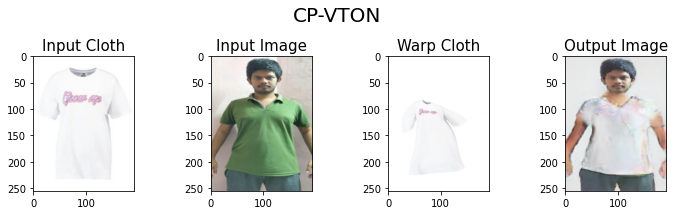

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.03257322311401367


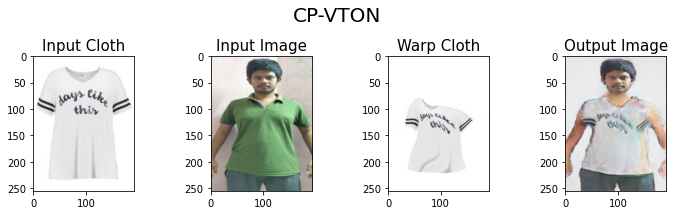

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.033022165298461914


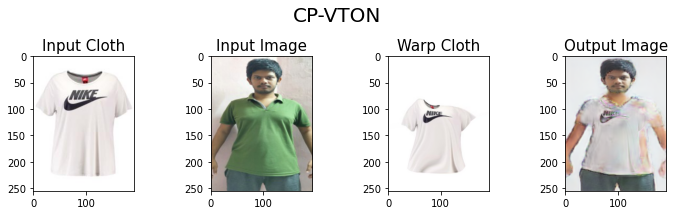

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.03218555450439453


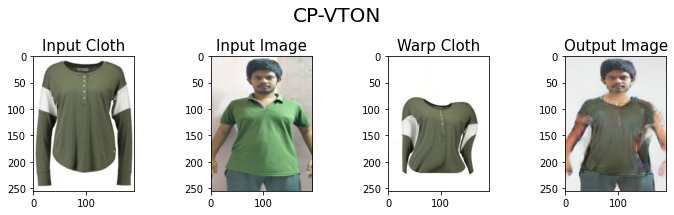

upper:27,bounder:237,left:19,right:176
after crop shape:(210, 157, 3)
time:0.03351306915283203


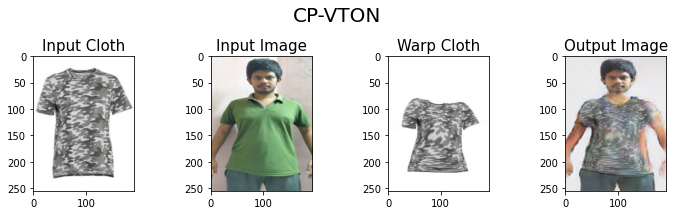

In [8]:
list_cloth = os.listdir('clothes')
for i, cloth_path in enumerate(list_cloth):
  predict('image_3.jpg', 'clothes/' + cloth_path, model, 'image_3' + str(i) + '.jpg')

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.032898902893066406


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


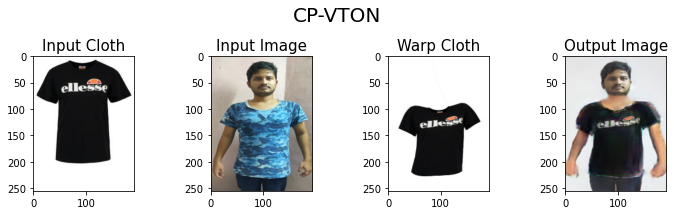

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.0327455997467041


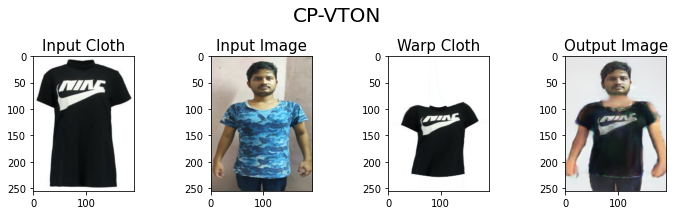

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.03214621543884277


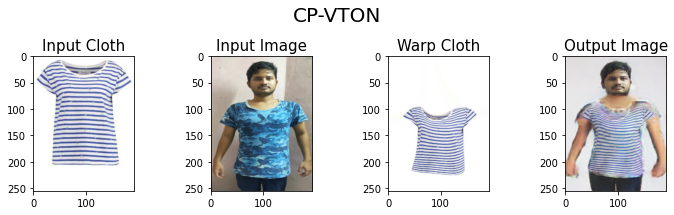

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.032439470291137695


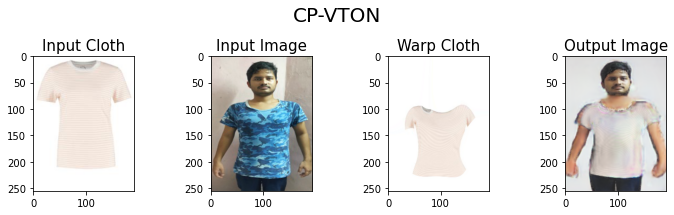

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.034023284912109375


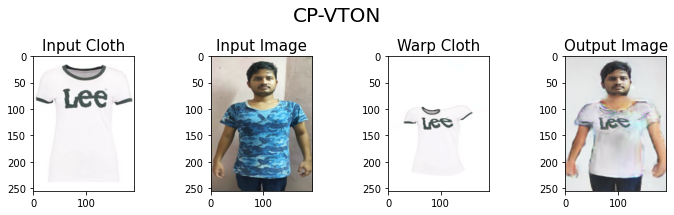

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.032785654067993164


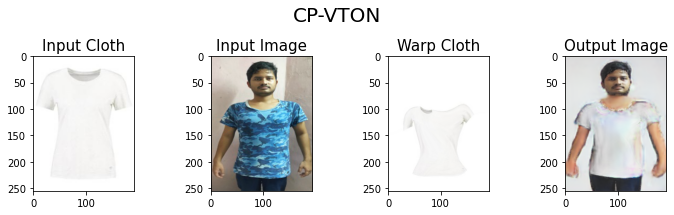

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.032167673110961914


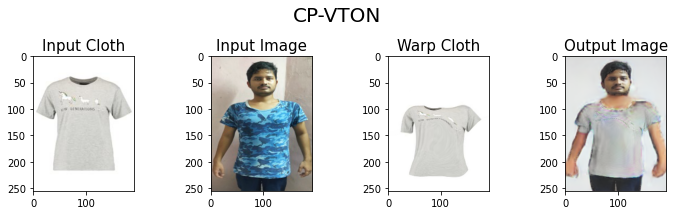

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.03252434730529785


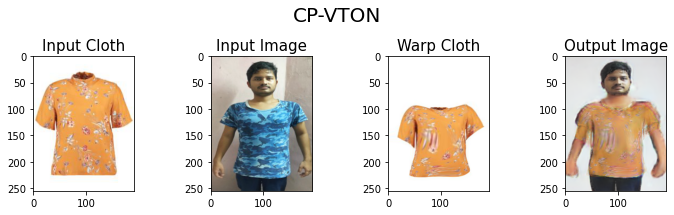

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.032599449157714844


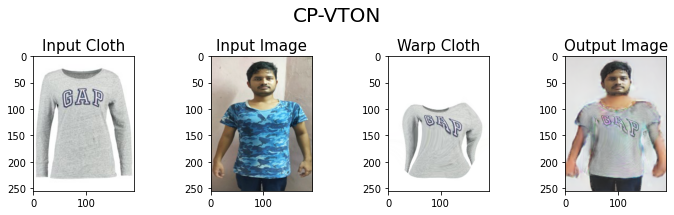

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.03273344039916992


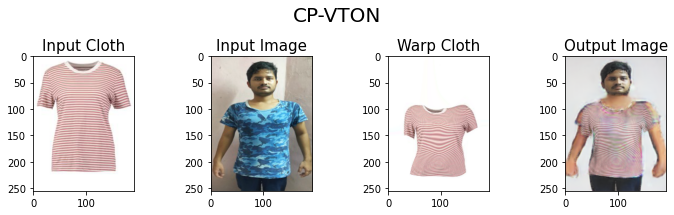

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.03232431411743164


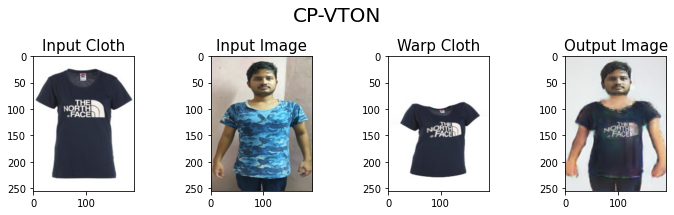

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.03227543830871582


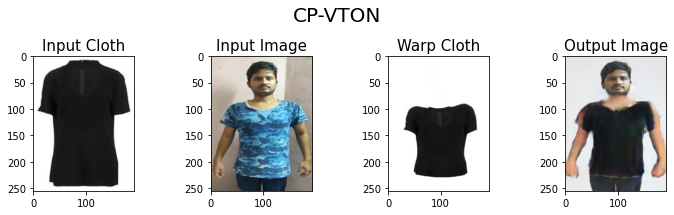

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.032221317291259766


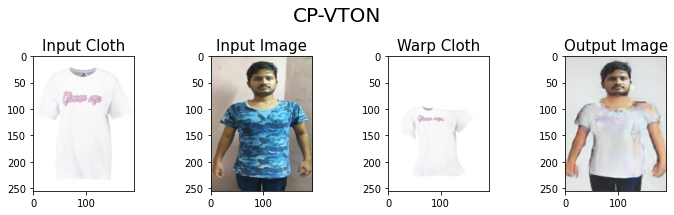

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.032196044921875


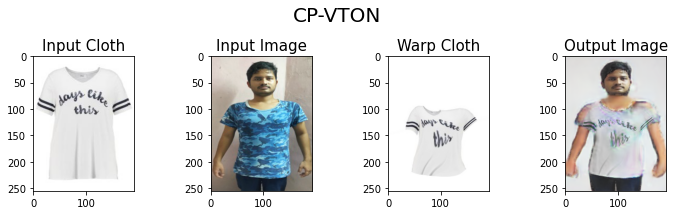

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.033930063247680664


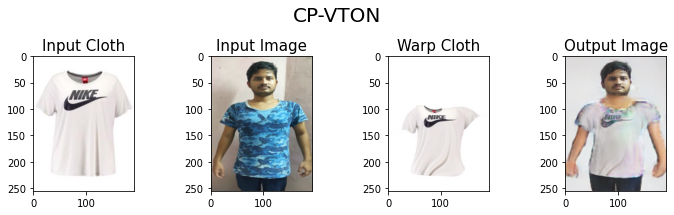

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.03233218193054199


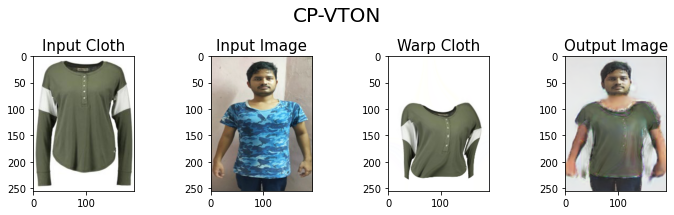

upper:10,bounder:243,left:12,right:186
after crop shape:(233, 174, 3)
time:0.03240704536437988


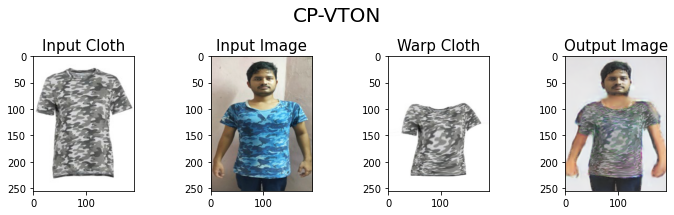

In [165]:
list_cloth = os.listdir('clothes')
for i, cloth_path in enumerate(list_cloth):
  predict('image_2.jpg', 'clothes/' + cloth_path, model, 'image_2' + str(i) + '.jpg')

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03264570236206055


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


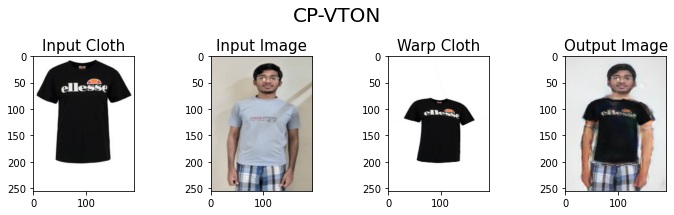

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03223109245300293


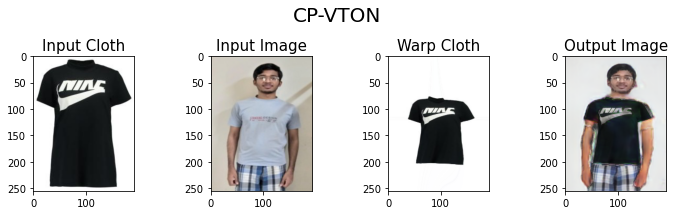

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03289461135864258


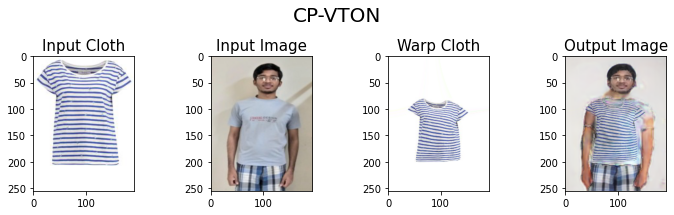

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03290367126464844


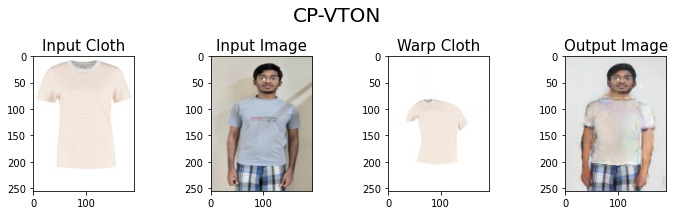

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.032292842864990234


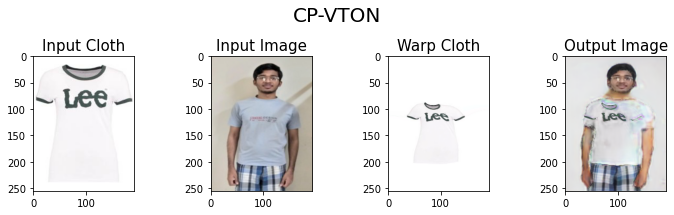

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03456735610961914


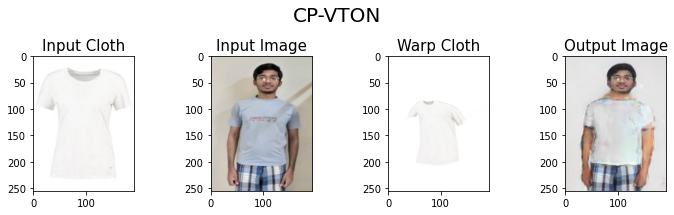

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03287792205810547


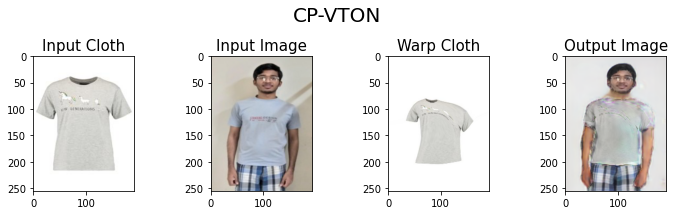

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03267550468444824


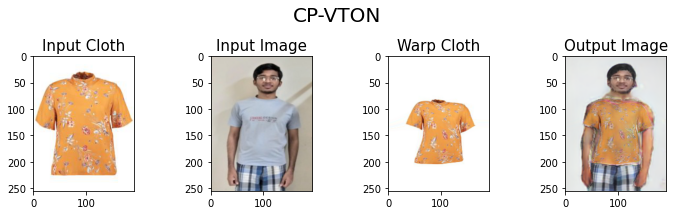

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.0405576229095459


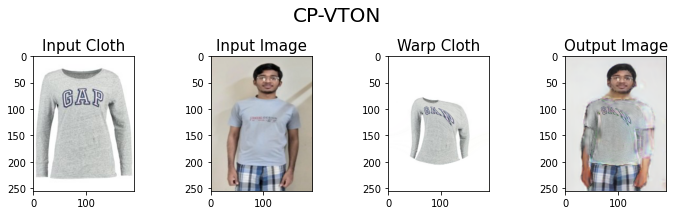

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.032315731048583984


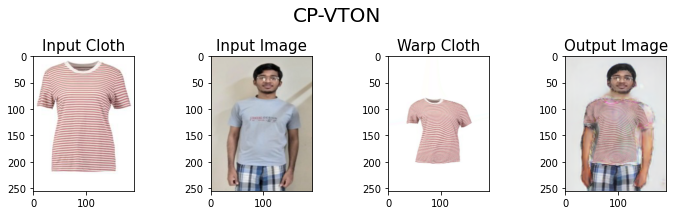

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03481435775756836


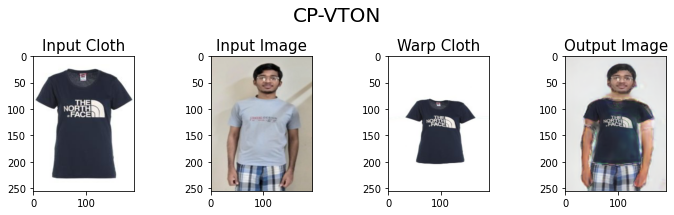

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03222823143005371


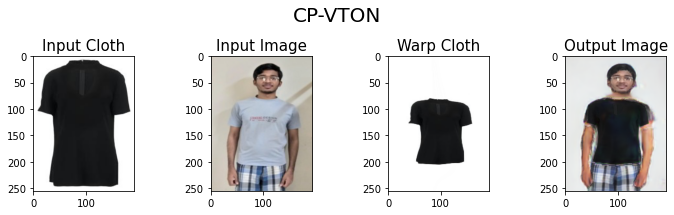

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03228306770324707


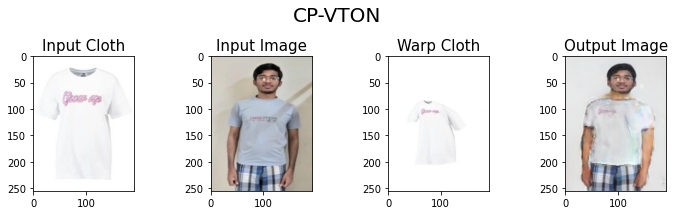

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03233981132507324


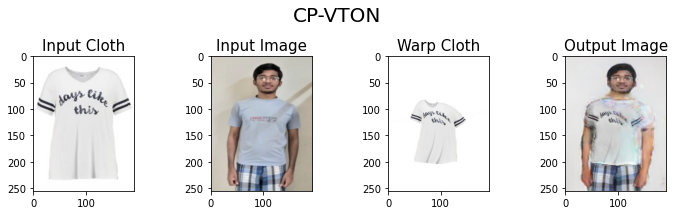

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03354072570800781


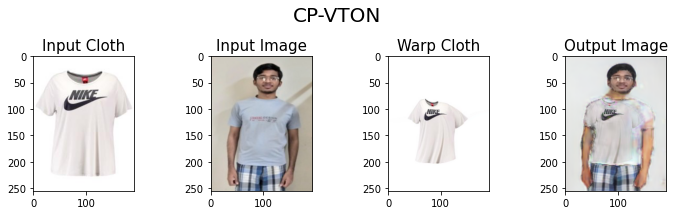

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.035253286361694336


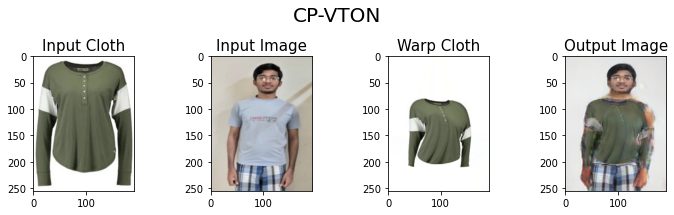

upper:8,bounder:218,left:14,right:171
after crop shape:(210, 157, 3)
time:0.03264045715332031


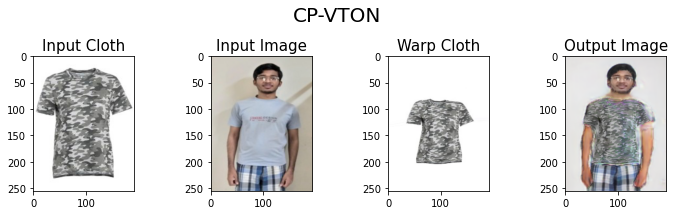

In [11]:
list_cloth = os.listdir('clothes')
for i, cloth_path in enumerate(list_cloth):
  predict('image_4.jpg', 'clothes/' + cloth_path, model, 'image_4' + str(i) + '.jpg')

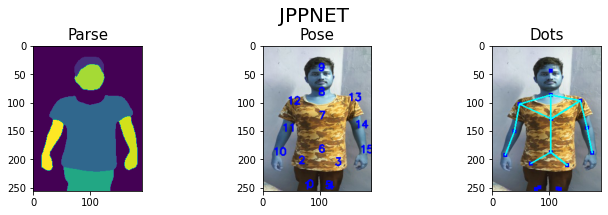

In [162]:
pred_pose()

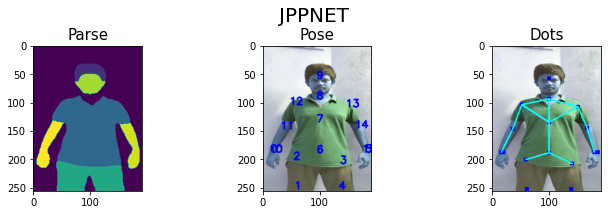

In [5]:
pred_pose()

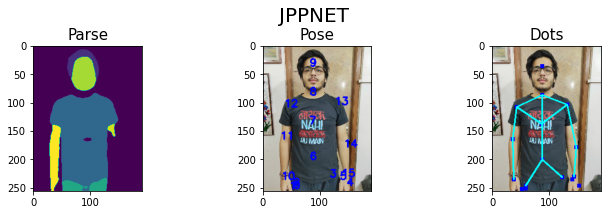

In [19]:
pred_pose()